### General intro

Thanks to the rapid advances in sequencing technologies generating genome-wide sequence datasets for any species has become routine and there is great interest in learning about the demographic and selective past of populations from sequence variation. The coalescent gives an elegant mathematical description of the ancestry of a sample of sequences from a more or less idealized population and, given its focus on samples, has become the bread and butter of modern population genetics. 

However, despite the flood of sequence data and the plethora of coalescent-based inference tools now available, many analyses of genome wide variation remain superficial or entirely descriptive. Developing efficient inference methods has been difficult for two reasons. First, analytic results for models of population structure and/or history are often restricted to average coalescence times and small (often pairwise) samples. Even when it is possible to derive the full distribution of genealogies for realistic samples sizes and models, the results are cumbersome and generally rely on automation (Lohse 2016). Second, and perhaps more fundamentally, dealing with recombination has proven extremely challenging and we still lack a full analytic description of genetic drift and recombination even under the simplest null models (in the absence of demography and selection). Thus, inference methods that incorporate linkage information generally rely on drastic simplifying assumptions about recombination (cite SMC papers and Song).

Given the severe limitations of relating sequence variation to mechanistic models analytically, coalescent simulations have become an integral part of inference in a number of ways: First, comparisons between analytic results against simulations serve as an important sanity check for both. Second, while it is often possible to use analytic approaches to obtain unbiased point estimates of demographic parameters by ignoring linkage (cite dadi and ), quantifying the uncertainty and potential biases in such estimates requires simulating data with linkage to conduct parametric bootstrapping. Finally, a range of inference approaches that rely on coalescent simulations directly to approximate the likelihood or - in a Bayesian setting - the posterior, of parameters under arbitrarily complex models of demography: Approximate Bayesian computation (ABC) (cite DIYABC, msBayes) has evolved ii) Approximate likelihood methods either based on SNPs (cite Excoffier) or blockwise data (cite ABLE). 

From the perspective of the user, inference tools are generally implemented with a command line or graphical user interface and are designed for a more or less narrow set of inference problems. Moreover, curent inference methods are based on a variety of coalescent simulators which are often. The aim of this chapter is to illustrate that how msprime (and its API) provides a flexible way to run and use coalescent simulations under under any model. We first explain the basic datastruture and methods msprimes for coalescent simulations and then show by the way of a set of simple practical examples how msprime can be used to obtain predictions for commonly used data summaries and diffferent models of demography. Finally, we show how msprime can be used to set up a ABC inference.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime
import numpy as np
import scipy
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG


## Running simulations

At the simplest level, coalescent simulation is about generating trees. These trees represent the simulated history of a sample of individuals drawn from an idealised population (in later sections we show how to vary the properites of this idealised population). The function ``msprime.sim_ancestry`` runs these simulations, and the parameters that we provide to this function determine the exact simulation that we run. It returns a ``TreeSequence`` object, which represents the full simulated history of the sample. In later sections we discuss the effects of recombination, when this ``TreeSequence`` contains a list of correlated trees. For now, we assume that there is no recombinations, and we use the method ``first()`` to obtain the tree object from this tree sequence. For example, here we simulate a history for a sample of three chromosomes:

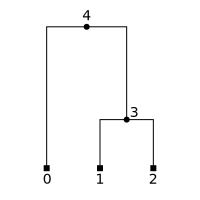

In [145]:
ts = msprime.sim_ancestry(3, ploidy=1)
tree = ts.first()
SVG(tree.draw())

In this tree we have 5 nodes. Nodes 0, 1 and 2 are *leaves*, and represent our samples. Node 3 is an *internal* node, and is the parent of 0 and 1. Node 4 is also an internal node, and is the root of the tree. In mpsrime, we always refer to nodes by their integer IDs and obtain information about these nodes by calling methods on the tree object. For example the code ``tree.children(4)`` will return the tuple ``(2, 3)`` here, as these are the node IDs of the children of the root node. Similarly, ``tree.parent(0)`` will return ``3``.

The height of nodes in a tree are determined by their *time*; this is how long ago the ancestor that corresponds the node was born. So, contemporary samples always have a node time of zero, and time values increase as we go upwards in the tree (and further back in time). Times in msprime are always measured in *generations*. 

When we run a single simulation, the resulting tree is a single random sample from the probability distribution of coalescent trees. Since a single random draw from any distribution is not usually informative, we nearly always need to run many different *replicate* simulations to obtain useful information. This simplest way to do this in msprime is to use the ``num_replicates`` argument.

In [150]:
N = 1000
mean_T_mrca = 0
for ts in msprime.sim_ancestry(10, num_replicates=N, ploidy=1):
    tree = ts.first()
    mean_T_mrca += tree.time(tree.root)
mean_T_mrca = mean_T_mrca / N
mean_T_mrca

1.879180282274613

In this example we run 1000 independent replicates of the coalescent for a sample of 10 chromosomes, and compute the mean time to the most recent common ancestor of the entire sample, or equivalently the root of the tree. (The value we obtain is a highly unrealistic 3.5 generations in the past; however, this is unsurprising since we have specified a highly unrealistic population model. See the next for more details on how to specify population models and interpret simulation times.) The ``simulate`` function behaves slightly differently when it is called with the ``num_replicates`` argument: rather than returning a single tree sequence we return an *iterator* over the individual replicates. What this essentially means is that we can use the convenient **for** loop construction to consider each simulation in turn, but without actually storing all these simulations. As a result, we can run millions of replicates using this method if needs be without using any extra storage.

When simulating coalescent trees, we are often interested in more than just the mean of the distribution of some statistic. Rather than compute the various summaries by hand (as we have done for the mean in the last example), it is much more convenient to store the result for each replicate and analyse this array after the simulations have completed. For example:

In [151]:
N = 1000
T_mrca = np.zeros(N)
for j, ts in enumerate(msprime.sim_ancestry(10, num_replicates=N, ploidy=1)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca), np.var(T_mrca)

(np.float64(1.748493485408263), np.float64(1.0851522050374443))

Here we simulate 1000 replicates, storing the time to the most recent common ancestor for each replicate in the array ``T_mrca``. (By default, time is measured in units of $4 N_e$ generations; see the next section for details.) We use the Python ``enumerate`` function here to simplify the process of efficiently inserting values into this array, which simply ensures that ``j`` for the first replicate, ``1`` for the second, and so on. Thus, by the time we finish the loop, the array has been filled with T_mrca values randomly generated under the coalescent. We then use the ``numpy`` library (which has an extensive suite of statistical functions) to compute the mean and variance of this array. This example is idiomatic, and we will use this type of approach throughout the rest of the tutorial.

It is usually more convenient to use the ``num_replicates`` argument to peform replication, but there are situations in which it is better the specify random seeds manually. For example, if simulations require a long time to run then we may wish to use multiple processes to run these simulations. To ensure that the seeds used in these different processes are unique, it is best to manually specify them. For example,

In [152]:
def run_simulation(seed):
    # TODO remove the int() here; fixed in version 0.5.0b2.
    ts = msprime.sim_ancestry(10, random_seed=int(seed), ploidy=1)
    tree = ts.first()
    return tree.time(tree.root)

N = 1000
seeds = np.random.randint(1, 2**32 - 1, N)
with multiprocessing.Pool(4) as pool:
    T_mrca = np.array(pool.map(run_simulation, seeds))
np.mean(T_mrca)

np.float64(1.7769060693688494)

In this example we create a list of 1000 seeds between 1 and 2^32 - 1(the range accepted by msprime) randomly using numpy. We then use the multiprocessing module to create a worker pool of four processes, and run our different replicates in these subprocesses. The results are then collected together in a numpy array so that we can easily process them. This approach is a straightforward way to fully utilise modern multi-core processors.

Specifying the same random seed for two different simulations (with the same parameters) ensures that we get precisely the same results from both simulations (at least, on the same computer and with the same software versions). This is very useful when we wish to examine the properties of a specific simulation (for example, when debugging), or if we wish to illustrate a particular example. We will often set the random seed in the examples in this tutorial for this reason.

## Population models

In the previous section the only parameters that we supplied to ``simulate`` were the ``sample_size`` and ``num_replicates`` parameters. This allows us to randomly sample trees with a given number of nodes, but has little connection with biological reality. The most imporant parameter used to model biology in coalescent simulations is the *effective population size*, *Ne*, or ``population_size``. This parameter simply rescales time; larger effective population sizes mean larger coalescence times:

In [153]:
def pairwise_T_mrca(population_size):
    N = 10000
    T_mrca = np.zeros(N)
    for j, ts in enumerate(msprime.sim_ancestry(2, population_size=population_size, num_replicates=N, ploidy=1)):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.5), pairwise_T_mrca(10), pairwise_T_mrca(100)

(np.float64(0.5074541074455474),
 np.float64(9.69816392479798),
 np.float64(99.81904372589933))

Thus, when we specify $N_e=10$ we get a mean coalescence time of about 20 generations, and when $N_e=100$ the mean coalescence time is about 200 generations. See Wakeley (citation) for details on the biological interpretation of effective population size. 

By default, $N_e = 1$ in msprime, which is equivalent to measuring time in units of $4N_e$ generations. It is very important to note that $N_e$ in msprime is the *diploid* effective population size, which means that all times are scaled by $4N_e$ (rather than 2Ne for a haploid coalescent). Thus, if we wish to compare the results that are given in the literature for a haploid coalescent, then we must set $N_e$ to 1/2 to compensate. For example, we know that the expected coalescence time for a sample of size 2 is 1, and this is the value we obtain from the ``pairwise_T_mrca`` function when we have $N_e=0.5$. We will usually assume that we are working in haploid coalescent time units from here on, and so set $N_e=0.5$ in most examples. However, when running simulations of a specific organism, it is substantially more convenient to use an appropriate estimated value for $N_e$ so that times are directly interpretable.


### Exponentially growing/shrinking populations

When we provide an $N_e$ parameter, this specifies a fixed effective population size. We can also model populations that are exponentially growing or contracting at some rate over time. Given a population size at the present $s$ and a growth rate $\alpha$, the size of the population $t$ generations in the past $s e^{-\alpha t}$. (Note again that time and rates are measured in units of *generations*, not coalescent units.)

In msprime, the initial size and growth rate for a particular population are specified using the ``PopulationConfiguration`` object. A list of these objects (describing the different populations; see the Population Structure section) are then provided to the simulate function. When providing a list of ``PopulationConfiguration objects``, the ``Ne`` parameter to ``simulate`` is not required, as the ``initial_size`` of the population configurations performs the same task. For example,


In [155]:
def pairwise_T_mrca(growth_rate):
    N = 10000
    T_mrca = np.zeros(N)   
    demography = msprime.Demography() 
    demography.add_population(initial_size=0.5, growth_rate=growth_rate)
    replicates = msprime.sim_ancestry(
        samples=2,
        demography=demography, 
        num_replicates=N,
        ploidy=1,
        random_seed=100)
    for j, ts in enumerate(replicates):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.05), pairwise_T_mrca(0), pairwise_T_mrca(-0.05)

(np.float64(0.4775720920641944),
 np.float64(0.4889637700421355),
 np.float64(0.5015256860964078))

Here we simulate the pairwise $T_{MRCA}$ for positive, zero and negative growth rates. When we have a growth rate of zero, we see that recover the usual result of 1.0 (as our initial size, and hence $N_e$, is set to $1/2$). When the growth rate is positive, we see that the mean coalescence time is reduced, since the population size is getting smaller as we go backwards in time, resulting in an increased rate of coalescence. Conversely, when we have a negative growth rate, the population is getting larger as we go backwards in time, resulting in a slower coalescence rate. (Care must be taken with negative growth rates, however, as it is possible to specify models in which the MRCA is never reached. In some cases this will lead to an error being raised, but it is also possible that the simulator will keep generating events indefinitely.)

## Mutations

We cannot directly observe gene genealogies; rather we observe the effects of mutations occuring on the branches of these trees. We are there very often interesting not just in the genealogies that are simulated by the coalescent process, but also in the results of mutational processes imposed on these trees. Msprime currently supports simulating mutations under the infinitely many sites model. This is accessed by the ``mutation_rate`` parameter to the ``simulate`` function. As usual, this rate is the per-generation rate.


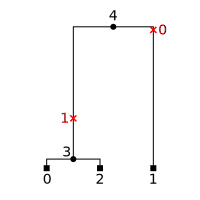

In [160]:
ts = msprime.sim_ancestry(3, ploidy=1, random_seed=7) #sequence_length=2 to get similar results, or change to non discrete genome
mutated_ts = msprime.sim_mutations(ts, rate=1, random_seed=7, discrete_genome=False)
tree = mutated_ts.first()
SVG(tree.draw())

In this example we have two mutations, shown by the red squares. Mutations occur above a given node in the tree, and all samples beneath this node will inherit the mutation. The infinite sites mutations used here are simple binary mutations, so that the ancestral state is 0 and the derived state is 1. One convenient way to access the resulting sample genotypes is to use the ``genotype_matrix()`` method, which returns an $m \times n$ numpy array, if we have $m$ variable sites and $n$ samples. Thus, if $G$ is the genotype matrix, $G[j, k]$ is the state of the $k$th sample at the $j$th site. In our example above, the site 0 has a mutation over node 3, and site 1 has a mutation over node 1, and so we get the following matrix:

In [161]:
mutated_ts.genotype_matrix()

array([[0, 1, 0],
       [1, 0, 1]], dtype=int32)

The genotype matrix is provides a convenient way of accessing this information, but will consume a great deal of memory for larger simulations. Msprime has an extensive suite of tools for efficiently working with sequence data and computing population genetics statistics, and a full review of these tools is beyond the scope of this document. Please consult the online documentation for more information on processing simulated sequences.

When comparing with analytical results regarding neutral genetic variation, it is very imporant to be aware of the way in which the mutation rates are defined in coalescent theory. For historical reasons, the scaled mutation rate $\theta$ is defined as $2N_e \mu$, where $\mu$ is the per-generation mutation rate. Since all times and rates are specified in units of generations in msprime, we must divide this factor of two out if we are to compare with analytical predictions. For example, the mean number of segregating sites for a sample of two is $\theta$; to run this in msprime we do the following:

In [172]:
N = 10000
theta = 5
S = np.zeros(N)
replicates = msprime.sim_ancestry(2, population_size=0.5, num_replicates=N, ploidy=1, discrete_genome=False)
for j, ts in enumerate(replicates):
    mutated_replicate = msprime.sim_mutations(ts, rate=theta, discrete_genome=False)
    S[j] = mutated_replicate.num_sites  # Number of segregrating sites.
np.mean(S)

np.float64(4.9801)

Note that here we set the mutation rate to $\theta / 2$ (to cancel out the factor of 2 in the definition of $\theta$) and $N_e = 1/2$ (so that time is measured in haploid coalescent time units). Such factor-of-two gymnastics are unfortunately unavoidable in coalescent theory.

## Population structure

Msprime supports a discrete-deme model of population structure in which $d$ panmictic populations exchange migrants according to the rates defined in an $d \times d$ matrix. This approach is very flexible, allowing us to simulate island models (in which all populations exchange migrants at a fixed rate), one and two dimensional stepping stone models (where migrants only move to adjacent demes) and other more complex migration patterns.

This population structure is declared in msprime using the ``population_configurations`` and ``migration_matrix`` parameters to the ``simulate`` function. The list of population configurations defines the populations; each element of this list must be a ``PopulationConfiguration`` instance (each population has independent initial population size and growth rate parameters). The migration matrix is a numpy array (or list of lists) of per-generation migration rates; $M[j,k]$ defines the fraction of population $j$ that consists of migrants from population $k$ in each generation.

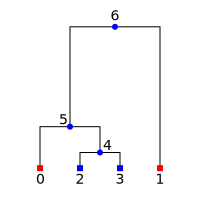

In [185]:
demography = msprime.Demography() 
demography.add_population(initial_size=2)
demography.add_population(initial_size=2)

demography.set_migration_rate(source=0, dest=1, rate=0.1)
demography.set_migration_rate(source=1, dest=0, rate=0)


ts  = msprime.sim_ancestry(
    samples={0:2, 1:2}, ploidy=1, 
    random_seed=2, demography=demography)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

We create our population model by first making a list of two ``PopulationConfiguration`` objects. For convenience here, we use the ``sample_size`` argument to these objects to state that we wish to have two samples from each population. This results in samples being allocated sequentially to the populations when ``simulate`` is called: 0 and 1 are placed in population 0, and samples 2 and 3 are place in population 1. We then declare our migration matrix, which is asymmetric in this example. Because ``M[0,1] = 0.1`` and ``M[0,1] = 0``, forwards in time, individuals can migrate from population 1 to population 0 but not vice-versa. This is shown in the tree for this simulation, where each node has been coloured by its population (red is population 0 and blue population 1). Thus, the leaf nodes 0 and 1 are both from population 0, and 2 and 3 are both from population 2 (as explained above). As we go up the tree, the first event that occurs is 2 and 3 coalescing in population 1, creating node 4. After this, 4 coalesces with with node 0, which has at some point before this migrated into deme 1, creating node 5. Node 1 also migrates into deme 1, where it coalesces with 5. Because migration is asymmetric here, the most recent common ancestor of the four samples *must* occur within deme 1.

The exact history of migration events is available if we use the ``record_migrations`` option. In the next example, we set up a symmetric island model and track every migration event:

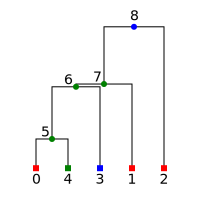

In [188]:
demography = msprime.Demography() 
demography.add_population(initial_size=3)
demography.add_population(initial_size=1)
demography.add_population(initial_size=1)

demography.set_migration_rate(source=0, dest=1, rate=1)
demography.set_migration_rate(source=0, dest=2, rate=1)

demography.set_migration_rate(source=1, dest=0, rate=1)
demography.set_migration_rate(source=1, dest=2, rate=1)

demography.set_migration_rate(source=2, dest=0, rate=1)
demography.set_migration_rate(source=2, dest=1, rate=1)



ts  = msprime.sim_ancestry(
    samples={0:3, 1:1, 2:1}, 
    demography=demography,
    record_migrations=True,
    ploidy=1,
    random_seed=101)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

Here we sample three nodes from population 0, but because we have a lot of migration the locations of coalescences are quite random. For example, the first coalescence occurs in deme 2 (green), after node zero has migrated in. To see the details of these migration events, we can examine the "migration records" that are stored by msprime. (These are not stored by default, as they may require a substantial amount of memory to store. The ``record_migrations`` parameter must be supplied to ``simulate`` to turn on this feature.) Migration records store complete information about the time, source and destination demes and the genomic interval in question. Here we are interested in the total number of migrations experienced by each node:

Text(0, 0.5, 'Number of migrations')

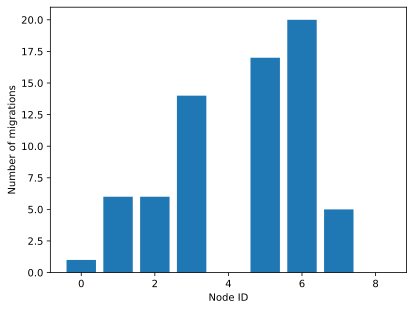

In [98]:
node_count = np.zeros(ts.num_nodes)
for migration in ts.migrations():
    node_count[migration.node] += 1
plt.bar(np.arange(ts.num_nodes), node_count)
plt.xlabel("Node ID")
plt.ylabel("Number of migrations")

We can see that node zero experienced very few migrations before it ended up in deme 2, where it coalesced with 4 (which never migrated). Node 2, on the other hand migrated 30 times before it finally coalesced with 7 in deme 0. Note that there are many more migrations events than nodes there, implying that most migration events are not identifiable from a genealogy in real data (CITE: http://onlinelibrary.wiley.com/doi/10.1111/j.1365-294X.2011.05247.x/abstract).

Other forms of migration are also possible between specific demes at specific times. These are one of a number of different demographic event, which are dealt with in the next section.


## Demographic events

Demographic events allow us to model more complex histories involving changes to the population structure over time. These are specified using the ``demographic_events`` parameter to ``simulate``. Each demographic event occurs at a specific time, and the list of events must be supplied in the order they occur (backwards in time). There are a number of different types of demographic event, which we examine in turn.

### Migration rate change

Migration rate change events allow us to update the migration rate matrix at some point in time. We can either update a single cell in the matrix or all (non-diagonal) entries at the same time.  

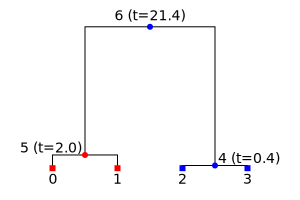

In [99]:
demography = msprime.Demography() 
demography.add_population(initial_size=2)
demography.add_population(initial_size=2)

demography.add_migration_rate_change(time=20, rate=1, source=0, dest=1)
ts  = msprime.sim_ancestry(
    samples={0:2, 1:2},
    demography=demography,
    ploidy=1,
    random_seed=2)

tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if tree.is_sample(u) else "{} (t={:.1f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))

As before, the sample 0 and 1, and 2 and 3 coalesce quickly within their own populations. However, because the migration rate between the populations is zero these lineages are isolated and would never coalesce without some change in demography. The migration rate change event happens at time 20, resulting in node 5 migrating to deme 1 soon afterwards. The lineages then coalesce at time 21.44.

### Mass migration
This class of event allows us to move some proportion of the lineages in one deme to another at a particular time. This allows us to model population splits and admixture events. 

Population splits occur when some fraction of the lineages from a population migrate to another population.

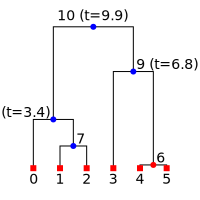

In [115]:
demography = msprime.Demography() 
demography.add_population(initial_size=3)
demography.add_population(initial_size=3)

demography.add_mass_migration(time=15, source=1, dest=0, proportion=1)

ts  = msprime.sim_ancestry(
    samples={0:3, 1:3},
    demography=demography,
    ploidy=1,
    random_seed=20)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.2f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))


Again, we have two isolated populations which coalesce down to a single lineage. The population split at time 15 (which produced all individuals in population 1), then results in this lineage migrating back to population 0, where it coalesces with the ancestor of the samples 0, 1 and 2.

Admixture events (i.e., where some fraction of the lineages move to a different deme) are specified in the same way:

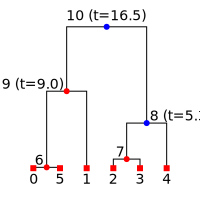

In [190]:
demography = msprime.Demography() 
demography.add_population(initial_size=6)
demography.add_population(initial_size=6)

demography.add_mass_migration(time=0.5, source=0, dest=1, proportion=0.5)
demography.add_migration_rate_change(time=1.1, rate=0.1)

ts  = msprime.sim_ancestry(
    samples={0:6, 1:0},
    demography=demography,
    ploidy=1,
    random_seed=5)
    
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.1f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels))

We begin in this example with 6 lineages sampled in population 0, zero samples in population 1, and with no migration between these populations. Then, at time 0.5, we have an admixture event where each of the 4 extant lineages (5, 7, 0 and 6) has a probability of 1/2 of moving to deme 1. Linages 0 and 6 migrate, and subsequently coalesce into node 8. Further back in time, at $t=1.1$, another demographic event occurs, changing the migration rate between the demes to 0.1, thereby allowing lineages to move between them. Eventually, all lineages end up in deme 1, where they coalesce into the MRCA at time $t=6.9$.

### Population parameter change

This class of event represents a simple change in the growth rate or size of a particular population. Since each population has it's own individual size and growth rates, we can change these arbitrarily as we go backwards in time. Keeping track of the actual sizes of different populations can be a little challenging, and for this reason msprime provides a ``DemographyDebugger`` class.

To illustrate this we consider a very simple example in which we have a single population experiencing an phase of exponential growth from 750 to 100 generations ago. The size of the population 750 generations ago was 2000, and it grew to 20,000 over the next 650 generations. The size of the population has been stable at this value for the past 100 generations. We can encode this model as follows:

In [122]:
N1 = 20000  # Population size at present
N2 = 2000   # Population size at start (forwards in time) of exponential growth.
T1 = 100    # End of exponential growth period (forwards in time)
T2 = 750    # Start of exponential growth period (forwards in time) 
# Calculate growth rate; solve N2 = N1 * exp(-alpha * (T2 - T1))
growth_rate = -np.log(N2 / N1) / (T2 - T1)
demography = msprime.Demography() 
demography.add_population(initial_size=N1)
demography.add_population_parameters_change(time=T1, growth_rate=growth_rate)
demography.add_population_parameters_change(time=T2, growth_rate=0)

dp = demography.debug()
dp.print_history()

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, 100) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌───────────────────────────────────────────┐
║    │       │     start│       end│growth_rate  │
║    ├───────────────────────────────────────────┤
║    │  pop_0│   20000.0│   20000.0│ 0           │
║    └───────────────────────────────────────────┘
╟    Events @ generation 100
║    ┌────────────────────────────────────────────────────────────────────────────┐
║    │  time│type        │parameters              │effect                         │
║    ├────────────────────────────────────────────────────────────────────────────┤
║    │   100│Population  │population=-1, growth_  │growth_rate → 0.00354 for all  │
║    │      │parameter   │rate=0.003542438604606  │populations                    │
║    │      │change      │2238                    │                               │
║    └──────────────────────────────────────────────

After we set up our model, we use the ``DemographyDebugger`` to check our calculations. We see that time has been split into three "epochs". From the present until 100 generations ago, we see that the population size is constant at 20,000. Then, we have a demographic event that changes the growth rate to 0.0035, which applies over the next epoch (from 100 to 750 generations ago). Over this time, the population grows from 2000 to 20,000, as we specified (note that the "start" and "end" of each epoch is looking *backwards* in time, as we consider epochs starting from the present and moving backwards). At generation 750 another event occurs, setting the growth rate for the population to 0. Then, the population size is constant at 20,000 from generation 750 until the indefinite past.

A more complex example involving a three population out-of-Africa human model is available in the online documentation.


## Ancient samples

Up to this point we have assumed that all samples are taken at the present time. However, msprime allows us to specify abitrary sampling times and locations, allowing us to simulate (for example) ancient samples.


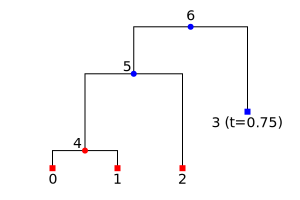

In [129]:
demography = msprime.Demography() 
demography.add_population(initial_size=3)
demography.add_population(initial_size=1)
demography.set_migration_rate(source=0, dest=1, rate=1)
demography.set_migration_rate(source=1, dest=0, rate=1)

ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, population=0, time=0), msprime.SampleSet(1, population=0, time=0),
        msprime.SampleSet(1, population=0, time=0), msprime.SampleSet(1, population=1, time=0.75), # Ancient sample in deme 1
    ],
    demography=demography,
    ploidy=1,
    random_seed=22)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u != 3 else "{} (t={:.2f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))


All of the trees that we previously considered had leaf nodes at time zero. In this case, the sampes 0, 1 and 2 are taken at time 0 in population 0, but node 3 is sampled at time 0.75 in population 1. Note that in this case we used the ``samples`` parameter to ``simulate`` to specify our samples. This is the most general approach to assigning samples, and allows for samples to be assigned to arbitrary populations and at arbitrary times.

## Recombination
One of the key innovations of msprime is that it makes simulation of the full coalescent with recombination possible at a whole chromosome scale. Adding recombination to a simulation is simple, requiring very minor changes to the methods given above.

In [179]:
ts = msprime.sim_ancestry(10, population_size=1e4, sequence_length=1e5, recombination_rate=1e-8, random_seed=3)
ts.num_trees

135

In this case, we provide two extra parameters: ``length``, which defines the lengths of the genomic region to be simulated, and ``recombination_rate``, which defines the rate of recombination per unit of sequence length, per generation. It is usually useful tp think of the length and recombination rate being defined in terms base-pairs (but note that these are continuous values, so this correspondence should not be taken too literally). For this example, we defined a sequence length of 10kb, and a recombination rate of $10^{-8}$ per base per generation. The result of this simulation is a *tree sequence* that contains 82 distinct trees.

Up to this point we have assumed that our simulations returned a single tree representing the genealogy of our sample. The inclusion of recombination, however, means that there may be more than one tree relating our samples. The ``TreeSequence`` object returned by msprime is a very concise and efficient representation of these highly correlated trees. To process these trees, we simply need to consider them one at a time, using the ``trees()`` iterator.

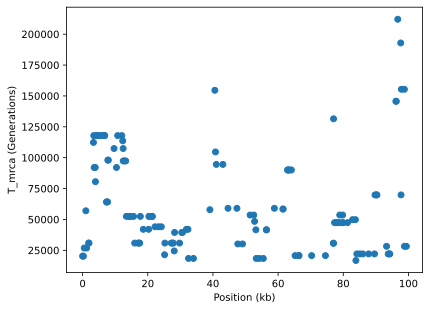

In [180]:
tmrca = np.zeros(ts.num_trees)
breakpoints = np.zeros(ts.num_trees)
for tree in ts.trees():
    tmrca[tree.index] = tree.time(tree.root)  
    breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o");

Here we plot the time of the MRCA of the sample for each tree across the sequence. We find the $T_{MRCA}$ as before, and plot this by the position of the left-most position of this tree. A full description of tree sequence and the methods for working with them is beyond the scope of this document; please see the online documentation for more details.

It is also possible to simulate data with recombination rates varying across the genome (e.g., in recombination hotspots). To do this, we first create a ``RecombinationMap`` instance that describes the properties of the recombination landscape that you with to simulate. We then supply this value to ``simulate`` using the ``recombination_map`` argument. In the following example, we simulate 100 samples using the human chromosome 22 recombination map from the HapMap project:

In [181]:
# Read in the recombination map and run the simulation.
infile = "genetic_map_GRCh37_chr22.txt"
recomb_map = msprime.RateMap.read_hapmap(infile)
ts = msprime.sim_ancestry(
    samples=100,
    population_size=10**4,
    recombination_rate=recomb_map,
    ploidy=1,
    random_seed=1)

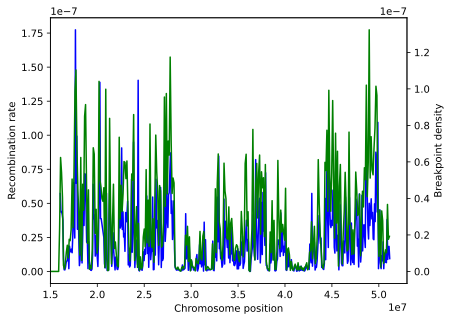

In [182]:
# Now plot the density of breakpoints along the chromosome
breakpoints = np.array(list(ts.breakpoints()))
# Now we get the positions and rates from the recombination
# map and plot these using 500 bins.
positions = np.array(recomb_map.right[1:])
rates = np.array(recomb_map.rate[1:])

num_bins = 500
v, bin_edges, _ = scipy.stats.binned_statistic(
    positions, rates, bins=num_bins)

x = bin_edges[:-1][np.logical_not(np.isnan(v))]
y = v[np.logical_not(np.isnan(v))]
fig, ax1 = plt.subplots()
ax1.plot(x, y, color="blue")
ax1.set_ylabel("Recombination rate")
ax1.set_xlabel("Chromosome position")
ax2 = ax1.twinx()
v, bin_edges = np.histogram(breakpoints, num_bins, density=True)
ax2.plot(bin_edges[:-1], v, color="green")
ax2.set_ylabel("Breakpoint density")
ax2.set_xlim(1.5e7, 5.3e7);

This plot shows the recombination rate and the locations of breakpoints from the simulation, and the density of breakpoints closely follows the recombination rate, as expected.

Although coordinates are specified in floating point values, msprime uses a discrete loci model when performing simulations. By default, the number of loci is very large ($~\sim 2^{32}$), and the locations of breakpoints are translated back into the coordinate system defined by the recombination map. However, the number of loci is configurable and can be specified if you wish to simulate a specific number of discrete loci.

In [183]:
recomb_map = msprime.RateMap.uniform(sequence_length=10, rate=1)
ts = msprime.sim_ancestry(2, recombination_rate=recomb_map)
list(ts.breakpoints())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Here we simulate a pairwise sample for a system with 10 loci, each of length 1 with recombination rate of 1 between adjacent loci per generation. In the output, we see that the breakpoints between trees now occur exactly at the integer boundaries bewtween these loci.